# For Mercari Price Suggestion Challenge

In [116]:
%matplotlib inline

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats, integrate
import seaborn as sns

In [118]:
sns.set(color_codes=True)

## Data exploration

In [13]:
train_data = pd.read_csv("./data/train.tsv", sep='\t')
test_data = pd.read_csv("./data/test.tsv", sep='\t')

In [23]:
print("there are {} rows in train_data and each row has {} columns".format(
    train_data.shape[0], train_data.shape[1]))
print("there are {} rows in test_data and each row has {} columns".format(
    test_data.shape[0], test_data.shape[1]))

there are 1482535 rows in train_data and each row has 8 columns
there are 693359 rows in test_data and each row has 7 columns


In [50]:
print("- train_data columns and their types: ")
print(train_data.dtypes)

print("- test_data columns and their types: ")
print(test_data.dtypes)

- train_data columns and their types: 
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object
- test_data columns and their types: 
test_id               int64
name                 object
item_condition_id     int64
category_name        object
brand_name           object
shipping              int64
item_description     object
dtype: object


In [83]:
train_data.sample(n=3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
873970,873970,18 inch doll sleeping bag,2,Kids/Toys/Dolls & Accessories,NaN,12.0,0,18 inch American girl doll size sleeping bag. ...
1025596,1025596,Milani AMORE MATTE bundle NEW W/LINERS,1,Beauty/Makeup/Lips,Milani,86.0,1,MILANI AMORE MATTE LIP CREME BUNDLE -9 MILANI ...
538092,538092,1 black beauty blending sponge,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,5.0,1,Brand new beauty blending sponges available I ...


In [84]:
test_data.sample(n=3)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
240829,240829,Gucci Belt,1,Men/Men's Accessories/Belts,Gucci,1,Gucci Guaranteee Authentic Mens Belt Coated Gr...
558894,558894,Rae Dunn TEA & COFFEE Canisters,1,Home/Kitchen & Dining/Coffee & Tea Accessories,NaN,0,Tea Canister
305849,305849,Wizard of Oz book cover locket necklace,1,Women/Jewelry/Necklaces,NaN,1,This is an adorable necklace. Book charm opens...


*test_id* and *train_id* could be ignored. *item_condition_id* and *shipping* are actually category data. *name*, *category_name*, *brand_name* and *item_description* are text data.
Since *price* is the only continuous data and it is the output, seems there is no need to check distribution and normalize data.

create a subset of train_data and test_data to explore

In [149]:
sub_train_data = train_data.sample(1000)
sub_test_data = test_data.sample(1000)

## Data Processing

### Drop *Train_id*

In [100]:
train_data.drop(columns = ['train_id']);

### category *item_condition_id* and *shipping*

In [78]:
train_data['item_condition_id'] = train_data['item_condition_id'].astype('category')
print(type(train_data['item_condition_id']))
train_data.item_condition_id.cat.categories

<class 'pandas.core.series.Series'>


Int64Index([1, 2, 3, 4, 5], dtype='int64')

In [79]:
train_data['shipping'] = train_data['shipping'].astype('category')
print(type(train_data['shipping']))
train_data.shipping.cat.categories

<class 'pandas.core.series.Series'>


Int64Index([0, 1], dtype='int64')

In [108]:
print("there are " + str(pd.isna(train_data['item_condition_id']).sum())
      + " items missing in item_condition_id")

there are 0 items missing in item_condition_id


In [109]:
print("there are " + str(pd.isna(train_data['shipping']).sum())
      + " items missing in shipping")

there are 0 items missing in shipping


In [97]:
train_data.dtypes

train_id                int64
name                   object
item_condition_id    category
category_name          object
brand_name             object
price                 float64
shipping             category
item_description       object
dtype: object

##### distribution

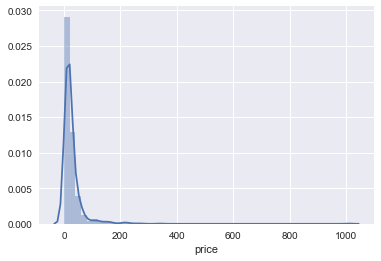

In [123]:
sns.distplot(sub_train_data['price'])

In [129]:
train_data['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

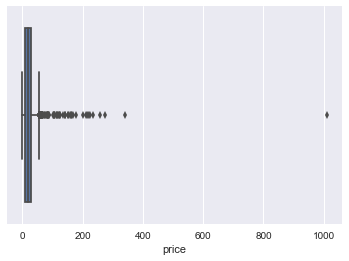

In [130]:
sns.boxplot(x=sub_train_data['price'])

Apply IQR to *price* and pick up all outlier items

In [141]:
def IQR(x):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    outlier_higher = q3 + 1.5 * iqr
    outlier_lower = q1 - 1.5 * iqr
    return outlier_lower, outlier_higher

In [154]:
outlier_lower, outlier_higher = IQR(sub_train_data['price'])
print("according to IQR, price oultier line is {} and {}".format(
    outlier_lower, outlier_higher))
outlier_sub_train_data = sub_train_data[sub_train_data['price'] > outlier_higher]
print("there are {} outlier in {} sub_train_data".format(
    outlier_sub_train_data.shape[0], sub_train_data.shape[0]))

according to IQR, price oultier line is -17.5 and 58.5
<class 'pandas.core.frame.DataFrame'>
there are 93 outlier in 1000 sub_train_data


In [155]:
outlier_lower, outlier_higher = IQR(train_data['price'])
print("according to IQR, price oultier line is {} and {}".format(
    outlier_lower, outlier_higher))
outlier_train_data = train_data[train_data['price'] > outlier_higher]
print("there are {} outlier in {} train_data".format(
    outlier_train_data.shape[0], train_data.shape[0]))

according to IQR, price oultier line is -18.5 and 57.5
there are 119352 outlier in 1482535 train_data


In [159]:
outlier_sub_train_data.sample(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1266847,1266847,kobe 8 bhm size 8.5,2,men/shoes/athletic,nike,95.0,1,9/10 vnds. 100% authentic. comes with og box.
552271,552271,women's size 32 regular rock revivals,3,women/jeans/boot cut,rock revival,86.0,0,all rhinestones in tact some wear on bottom bu...
184016,184016,ray-ban clubmaster,3,women/women's accessories/sunglasses,ray-ban,64.0,0,authentic sunglasses with 2 small scratches on...
937798,937798,iphone 6 16 gb black t-mobile,3,electronics/cell phones & accessories/cell pho...,apple,174.0,0,body has very small damage. minor knicks aroun...
569176,569176,lularoe fall woven print carly small,1,women/dresses/asymmetrical hem,NaN,116.0,0,brand new with tags. lularoe carly unicorn pri...
1132606,1132606,beats solo 2 wireless headphones,2,"electronics/tv, audio & surveillance/headphones",beats,121.0,0,they are rose gold! i bought these like a few ...
1405479,1405479,asst. disney frozen outfits girls 4/5/6,3,kids/girls (4+)/tops & t-shirts,disney,73.0,0,several bundles of clothes as pictured..ignore...
556990,556990,rae dunn new mixing bowls,1,home/kitchen & dining/dining & entertaining,rae dunn,110.0,0,no description yet
1162101,1162101,ipod touch 5th generation,3,electronics/cell phones & accessories/cell pho...,apple,86.0,0,16gb ipod touch 5th generation. have had for 2...
212707,212707,james avery,3,women/jewelry/earrings,james avery,99.0,0,"earrings, no backs two charms"


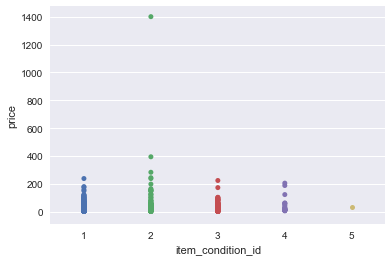

In [157]:
sns.stripplot(x="item_condition_id", y='price', data=sub_train_data)

### process text data

#### lowercase

In [106]:
train_data['name'] = train_data['name'].str.lower();
train_data['category_name'] = train_data['category_name'].str.lower();
train_data['brand_name'] = train_data['brand_name'].str.lower();
train_data['item_description'] = train_data['item_description'].str.lower();

In [107]:
train_data.sample(n=5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1042670,1042670,5 james patterson book bundle hard cover,3,other/books/literature & fiction,NaN,16.0,0,"all in great condition, price includes all 5bo..."
136507,136507,lilly pulitzer fan sea pants towel set,1,home/home décor/home décor accents,NaN,24.0,0,"set of 2 brand new 16x19"" kitchen or bath hand..."
1394272,1394272,rock revival jean's,3,women/jeans/boot cut,rock revival,28.0,0,inseam 29 worn a couple times.
1188349,1188349,brandnew original samsung charger set,1,electronics/cell phones & accessories/cell pho...,NaN,12.0,1,"dear customer, i try my best to make my custom..."
531591,531591,black mini teardrop makeup blender,1,beauty/tools & accessories/makeup brushes & tools,NaN,5.0,1,brand new in package black mini teardrop beaut...


#### missing data

In [114]:
print("there are " + str(pd.isna(train_data['name']).sum())
      + " items missing in name")
print("there are " + str(pd.isna(train_data['category_name']).sum())
      + " items missing in category_name")
print("there are " + str(pd.isna(train_data['brand_name']).sum())
      + " items missing in brand_name")
print("there are " + str(pd.isna(train_data['item_description']).sum())
      + " items missing in item_description")

there are 0 items missing in name
there are 6327 items missing in category_name
there are 632682 items missing in brand_name
there are 4 items missing in item_description
